# Notebook 2: Signal Processing – Fourier Analysis and Filtering

In the previous notebook, we loaded and visualized the spindle current signal from a single milling experiment.

In this notebook, we will focus on signal processing techniques to analyze and clean the data.  
Specifically, we will apply:

- **Fourier Transformation** to investigate the frequency components of the spindle current signal  
- **Filtering** techniques to reduce noise and extract relevant features from the signal  

We start by importing the necessary libraries, loading the same dataset for consistency and visualizing the raw spindle current signal `ACT_CURRENT_S` both in the time domain and in the frequency domain.

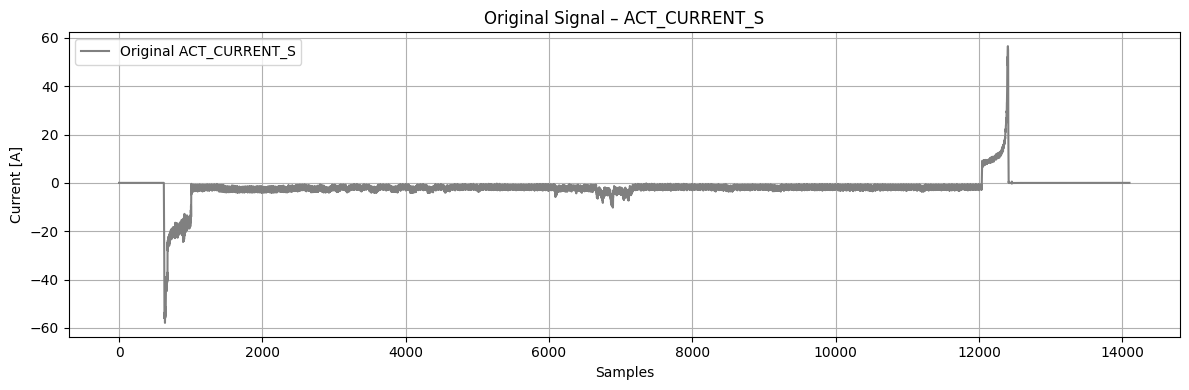

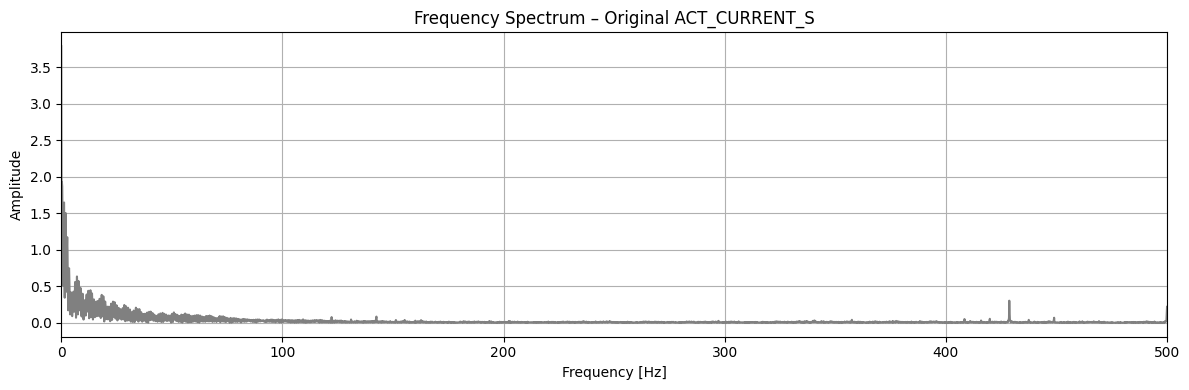

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import seaborn as sns
import random
from scipy.fft import fft, fftfreq

df = pd.read_csv("25_D6_Al_Rough_1.csv")

# Sampling rate
fs = 2000.0  # Hz
cutoff = 50.0  # Cutoff frequency in Hz
df_filtered = df.copy() # Creates a copy of the DataFrame to avoid modifying the original data.

# Plot 1: Original signal
plt.figure(figsize=(12, 4))
plt.plot(df['ACT_CURRENT_S'], color='gray', label='Original ACT_CURRENT_S')
plt.title('Original Signal – ACT_CURRENT_S')
plt.xlabel('Samples')
plt.ylabel('Current [A]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

signal = df['ACT_CURRENT_S'].to_numpy()

# Parameters
N = len(signal)       # Number of samples
T = 1.0 / fs          # Sample spacing (1 / sampling rate)

# FFT Original Signal
yf_original = fft(signal)
xf = fftfreq(N, T)[:N // 2]  # Frequenzachse (positive Frequenzen)
amplitude_original = 2.0 / N * np.abs(yf_original[0:N // 2])

# Plot 2: Original Frequency Spectrum
plt.figure(figsize=(12, 4))
plt.plot(xf, amplitude_original, color='gray')
plt.title('Frequency Spectrum – Original ACT_CURRENT_S')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 500)  # Zoom to 0-500 Hz
plt.tight_layout()
plt.show()

## Interpretation of the Time and Frequency Domain Plots

- The **first plot** shows the original spindle current signal (`ACT_CURRENT_S`) over time (sample-wise).  
  It includes both the active machining phase and non-cutting periods such as spindle ramp-up and ramp-down.

- In the **second plot**, we apply a **Fast Fourier Transform (FFT)** to convert the signal from the time domain to the frequency domain.  
  This allows us to identify the dominant frequency components and detect **high-frequency noise** present in the signal.

---

The x-axis of the frequency spectrum is limited to **0–500 Hz**, which is the most relevant range for monitoring typical milling processes.

We observe that the signal contains **high-frequency components**, which are most likely caused by electrical noise, mechanical vibrations, or other system disturbances not related to the actual cutting process.

---

## Why Apply a Low-Pass Filter?

To clean the signal and focus only on relevant process information, we apply a **low-pass filter** with a **cutoff frequency of 50 Hz**.

This choice is justified because:

- Most meaningful dynamics of the milling process (e.g., tool–workpiece interaction, load changes) occur in the **low-frequency range**.
- Frequencies above ~50 Hz typically reflect noise or effects unrelated to tool engagement.
- Filtering improves the **signal-to-noise ratio** and allows more robust feature extraction for machine learning or monitoring.

→ In the next step, we will apply a **Butterworth low-pass filter** to smooth the signal and suppress the unwanted high-frequency content.


## Signal Filtering – Butterworth Low-Pass Filter

In this section, we define a Butterworth low-pass filter to remove high-frequency noise from the raw sensor signals. The filter design is based on a specified cutoff frequency and sampling rate.  

First, the `butter_lowpass` function calculates the filter coefficients based on the cutoff frequency and filter order.  
Then, the `butter_lowpass_filter` function applies the filter to the data using forward and backward filtering (`filtfilt`) to avoid phase shifts.  

To ensure robustness, the function includes error handling for cases where the signal contains NaN or infinite values or is too short for proper filtering.


In [6]:
# Define a low-pass Butterworth filter
def butter_lowpass(cutoff, fs, order=5):
    """
    Designs a low-pass Butterworth filter.

    :param cutoff: The cutoff frequency of the filter in Hz.
    :param fs: The sampling frequency of the signal in Hz.
    :param order: The order of the Butterworth filter (default is 5).
    :return: Tuple containing the filter coefficients (b, a).
    """
    nyquist_frequency = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist_frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply the Butterworth low-pass filter to the data
def butter_lowpass_filter(data, cutoff, fs, order=5):
    """
    Applies a low-pass Butterworth filter to the input data.

    :param data: The signal to be filtered (array-like or pandas Series).
    :param cutoff: The cutoff frequency of the filter in Hz.
    :param fs: The sampling frequency of the signal in Hz.
    :param order: The order of the Butterworth filter (default is 5).
    :return: The filtered signal as a NumPy array or the original signal 
             if an error occurs.
    :raises ValueError: If the input data contains NaN or infinite values, 
                        or if the data length is insufficient for filtering.
    """
    try:
        # Check if the data contains NaN or infinite values
        if np.isnan(data).any() or np.isinf(data).any():
            raise ValueError("Data contains NaN or infinite values.")

        b, a = butter_lowpass(cutoff, fs, order=order)

        # Ensure the dataset length is sufficient for filtering
        padlen = 3 * max(len(b), len(a))        
        if len(data) > padlen:
            y = filtfilt(b, a, data)  # Apply forward and backward filtering
        else:
            raise ValueError("Data length is insufficient for filtering.")

        return y

    except ValueError as ve:
        print(f"ValueError: {ve}")
        return data  # Return original data in case of error

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return data  # Return original data in case of error


## Signal Filtering Results – Time and Frequency Domain (After Filtering)

*In this section, the previously defined Butterworth low-pass filter is applied to the spindle current and force signals.  
A cutoff frequency of 50 Hz is used to suppress high-frequency noise, preserving only the low-frequency components relevant for process analysis.*

The filtering is applied to the following signals:
- Spindle currents: `ACT_CURRENT_X`, `ACT_CURRENT_Y`, `ACT_CURRENT_Z`, `ACT_CURRENT_S`
- Force signals: `Fx_N`, `Fy_N`, `Fz_N`

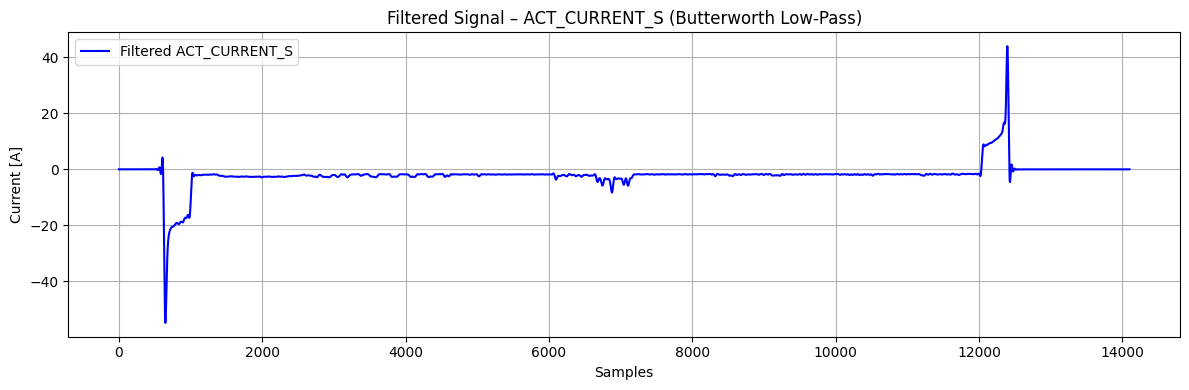

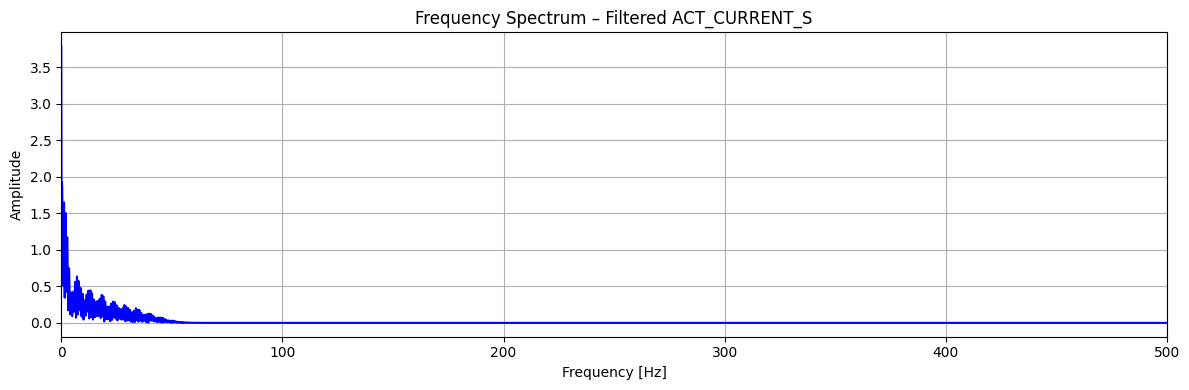

In [8]:
# Apply low-pass filtering to the currents
df_filtered.loc[:, 'ACT_CURRENT_X'] = butter_lowpass_filter(df_filtered['ACT_CURRENT_X'], cutoff, fs)
df_filtered.loc[:, 'ACT_CURRENT_Y'] = butter_lowpass_filter(df_filtered['ACT_CURRENT_Y'], cutoff, fs)
df_filtered.loc[:, 'ACT_CURRENT_Z'] = butter_lowpass_filter(df_filtered['ACT_CURRENT_Z'], cutoff, fs)
df_filtered.loc[:, 'ACT_CURRENT_S'] = butter_lowpass_filter(df_filtered['ACT_CURRENT_S'], cutoff, fs)
    
# Apply low-pass filtering to the forces
df_filtered.loc[:, 'Fx_N'] = butter_lowpass_filter(df_filtered['Fx_N'], cutoff, fs)
df_filtered.loc[:, 'Fy_N'] = butter_lowpass_filter(df_filtered['Fy_N'], cutoff, fs)
df_filtered.loc[:, 'Fz_N'] = butter_lowpass_filter(df_filtered['Fz_N'], cutoff, fs)



# Plot 3: Filtered signal
plt.figure(figsize=(12, 4))
plt.plot(df_filtered['ACT_CURRENT_S'], color='blue', label='Filtered ACT_CURRENT_S')
plt.title('Filtered Signal – ACT_CURRENT_S (Butterworth Low-Pass)')
plt.xlabel('Samples')
plt.ylabel('Current [A]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

signal_filtered = df_filtered['ACT_CURRENT_S'].to_numpy()

# Parameters
N = len(signal_filtered)       # Number of samples
T = 1.0 / fs          # Sample spacing (1 / sampling rate)

# FFT Filtered Signal
yf_filtered = fft(signal_filtered)
amplitude_filtered = 2.0 / N * np.abs(yf_filtered[0:N // 2])

# Plot 4: Filtered Frequency Spectrum
plt.figure(figsize=(12, 4))
plt.plot(xf, amplitude_filtered, color='blue')
plt.title('Frequency Spectrum – Filtered ACT_CURRENT_S')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 500)  # Zoom to 0-500 Hz
plt.tight_layout()
plt.show()